S0 :: Imports

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
import ipynbname#necessary to get filepath to jupyter notebook file

_FILE_DIR = ipynbname.path().parent#obtain directory of this file
_PROJ_DIR = _FILE_DIR.parent#obtain main project directory
_DATA_DIR = _PROJ_DIR / "dataset"
_DATAEXTR_DIR = _PROJ_DIR / "dataExtracted"
_VIS_DIR = _PROJ_DIR / "visualizations"
_FILE_DIR

PureWindowsPath('c:/Users/piras/Desktop/Uni/Python/Semester 3/NetworkAnalysis/UCNA/visualizations')

S1 :: Load dataframes

In [ ]:
mode = 'ping'
status = 'targeted'

avgConnectivityDf = pd.read_csv(str(_DATAEXTR_DIR / f"avg_{mode}_{status}.csv"))

S3 :: Function to filter dataset for relevant iterations and only top 10

In [8]:
def get_top10(n, mode, relative= True):
    global avgConnectivityDf
    avgConnectivityDf = pd.read_csv(str(_DATAEXTR_DIR / f"avg_{mode}_{status}.csv"))
    # set start of the slicing
    start = n-30
    
    if relative:
        ConnDf = (avgConnectivityDf / avgConnectivityDf.iloc[0]).copy()
    else:
        ConnDf = avgConnectivityDf.copy()

    # only get data for chosen period
    idx = list(range(start, n))
    conn_df = pd.DataFrame(ConnDf.loc[idx])

    asc = False if mode == 'connectivity' else True
    
    # sort by the last relevant iteration so that the legend is in order
    return conn_df.T.sort_values(by= n-1, axis= 0, ascending= asc)

S4 :: Map each country to a specific color

In [9]:
columns = avgConnectivityDf.columns
colors = sns.color_palette("turbo", len(columns))

col_dict = {columns[i] : colors[i] for i in range(len(columns))}

S5 :: Interaction !!

interactive(children=(IntSlider(value=30, description='Iteration window', max=502, min=30), Text(value='connec…

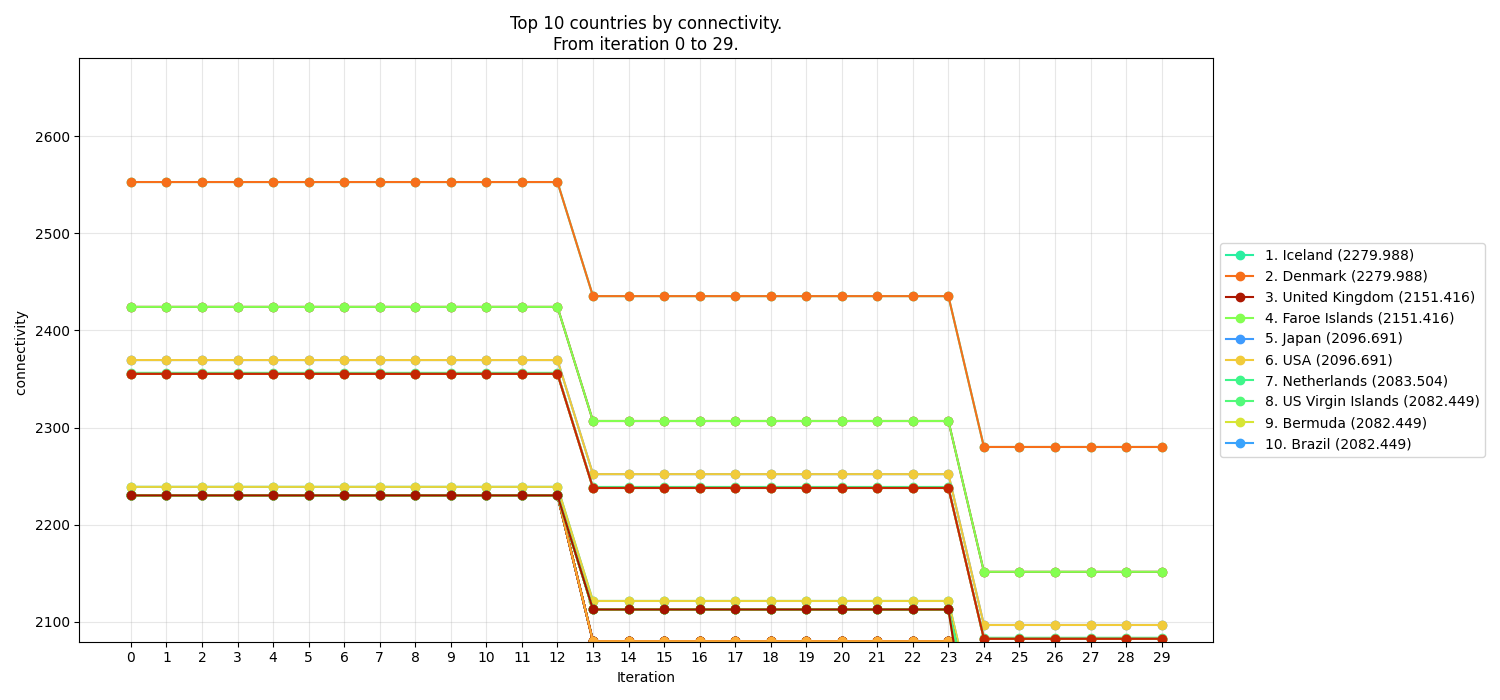

In [10]:
%matplotlib widget

fig, ax = plt.subplots(figsize= (15, 7))

def update_plot(n, mode= mode, relative= False):

    # get entries    
    conn_df = get_top10(n, mode, relative)
    
    # set start
    start = n-30

    ax.clear()
    ax.grid(alpha= 0.3)
    
    # keep track of minimum connectivity to adjust graph lims
    limit = np.inf if mode == 'connectivity' else 0

    # plot lines
    idx = list(range(start, n))
    for i, (_, r) in enumerate(conn_df.iterrows()):
        # use top10 of final iteration to label countries
        if i < 10:

            # update min conn if needed
            val = r.values[-1]
            if (val <= limit) and mode == 'connectivity':
                limit = val
            elif (val >= limit) and mode == 'ping':
                limit= val

            l = f"{i+1}. {r.name} ({round(r.values[-1], 3)})" 
        
        # no label for countries outside of the top10
        else:
            l = None

        ax.plot(list(range(len(idx))), r.values, marker= 'o', label= l, c= col_dict[r.name])
    

    ax.set_xticks(list(range(len(idx))), idx)

    if relative and mode == 'connectivity':
        ax.set_ylim(-0.1, 1.1)
        ax.set_yticks([0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0])
        ax.axhline(y= 0.5, linestyle= '--', c= 'darkred') 
    
    elif relative and mode == 'ping':
        ax.set_ylim(0.9, 3.1)
        ax.set_yticks([1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0])
        ax.axhline(y= 2, linestyle= '--', c= 'darkred') 

    elif mode == 'connectivity':
        ax.set_ylim(bottom= limit-3)
    
    else:
        ax.set_ylim(top = limit+3)

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    ax.set_ylabel(f"{mode} {'(relative)' * relative}")
    ax.set_xlabel("Iteration")
    ax.set_title(f"Top 10 countries by {mode}.\nFrom iteration {start} to {n-1}.")
    
    fig.tight_layout()
    fig.canvas.draw_idle()


n_slider = widgets.IntSlider(value= 30, min= 30, max= len(avgConnectivityDf), step= 1, description= 'Iteration window')

interact(update_plot, n= n_slider)
plt.show()